In [ ]:
!pip install adversarial-robustness-toolbox

import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
import pandas as pd

import torch.optim as optim
import numpy as np

from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist



matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import os
user = os.uname().nodename
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

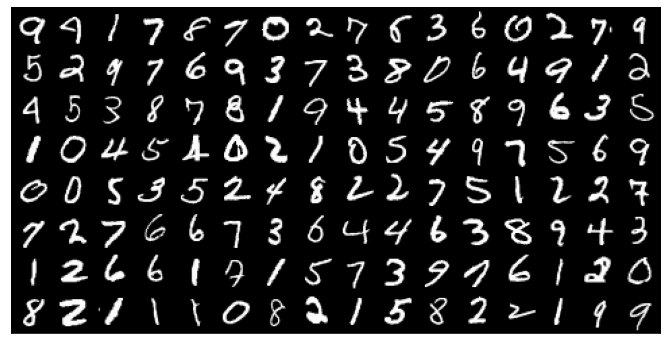

In [ ]:
show_batch(train_dl)

In [ ]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [ ]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1), #first argument changed from 3 to 1
    nn.MaxPool2d(2, 2)
)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 8, 14, 14])


In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MNIST_CNN3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(6272, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))

    def forward(self, xb):
        return self.network(xb)

'''
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
'''


model1 = MNIST_CNN3()
model1

MNIST_CNN3(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [ ]:
class MNIST_CNN4(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10))

    def forward(self, xb):
        return self.network(xb)
model2 = MNIST_CNN4()
model2

MNIST_CNN4(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(1024, 1024, kernel_size=(3, 3), stride=

In [ ]:
model = model1

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 28, 28])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0260, -0.0100,  0.0388,  0.0080,  0.0166, -0.0439, -0.0647, -0.0529,
        -0.0183,  0.0500], grad_fn=<SelectBackward0>)


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        print(result)

In [ ]:
model = to_device(model, device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.302743673324585, 'val_acc': 0.10244140774011612}

In [ ]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [ ]:
testno = 0
log_3layers = {}
log3layers = {}

In [ ]:
num_epochs = 1
learning_rate = 0.000001

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def accuracy(predictions):
    return (np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test))

In [ ]:
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [ ]:
def trainandtest(n):
    for i in range(n):
        global testno
        testno+=1
        classifier.fit(x_train, y_train, batch_size=128, nb_epochs=num_epochs)
        benign_predictions = classifier.predict(x_test)
        benign_accuracy = accuracy(benign_predictions)*100

        attack = FastGradientMethod(estimator=classifier, eps=1.5)
        x_test_adv = attack.generate(x=x_test)


        adv_predictions = classifier.predict(x_test_adv)
        adv_accuracy = accuracy(adv_predictions) * 100
        e = datetime.datetime.now()
        log3layers[testno] = {'Test Number':testno,
                              'Learning Rate': learning_rate,
                              'Number of Epochs':num_epochs,
                              'Accuracy with Benign Test Set':benign_accuracy,
                              'Accuracy with Adversarial Test Set':adv_accuracy,
                             'Machine':user
                             }
        print("iteration ",testno," over")

In [ ]:
trainandtest(10)

iteration  31  over
iteration  32  over
iteration  33  over
iteration  34  over
iteration  35  over
iteration  36  over
iteration  37  over
iteration  38  over
iteration  39  over
iteration  40  over


In [ ]:
df = pd.DataFrame(data = log3layers)
df.T

,Test Number,Learning Rate,Number of Epochs,Accuracy with Benign Test Set,Accuracy with Adversarial Test Set,Machine
1,1,0.001,1,98.13,11.55,69864cfa8472
2,2,0.001,1,99.07,14.79,69864cfa8472
3,3,0.001,1,98.72,16.13,69864cfa8472
4,4,0.001,1,99.13,14.35,69864cfa8472
5,5,0.001,1,98.88,13.6,69864cfa8472
6,6,0.001,1,99.14,12.17,69864cfa8472
7,7,0.001,1,99.08,13.2,69864cfa8472
8,8,0.001,1,99.24,11.95,69864cfa8472
9,9,0.001,1,99.33,14.06,69864cfa8472
10,10,0.001,1,99.15,13.27,69864cfa8472
